# Model Evaluation for Breast Cancer Classification (Health Analytics Case Study)




---



In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import RandomSearch
from sklearn.linear_model import LogisticRegression



In [ ]:
# Import the Wisconsin breast cancer dataset from the sklearn library.
# Load the Wisconsin breast cancer dataset into the cancer variable.
cancer = load_breast_cancer()

# Convert the predictors into a pandas DataFrame and have the DataFrame column names be the feature names.
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)

# Convert the outcome variable into a pandas DataFrame and name the DataFrame column as Target.
y = pd.Series(cancer.target, name="target")


################################################################################

The dataset is initially split into a large training set (90%) and a smaller, stratified test set (10%) for final evaluation, ensuring class balance and reproducibility. Next, the training set is then further divided into a smaller training subset (81% of the original) and two distinct validation sets (9% each). Applying stratification and random states to these sets facilitates rigors hyperparameter tuning and mitigates data leakage.

################################################################################

In [ ]:
# Splitting the data into training and testing with the training having 90% of the data and testing having 10%
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X,y, stratify= y, random_state = 75, test_size = 0.1 ) # The random state is set at 75 for reproducibility of results

# Splitting the data into training and validation, with the training having 90% of the initial training data and validation having 10% of the initial training data
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, y_train_initial, stratify= y_train_initial, random_state = 4, test_size = 0.1)# The random state is set at 4 for reproducibility of results


################################################################################

This code effectively standardises the features to optimise the performance of the model. This approach not only mitigates the risk of data leakage but also ensures consistent scaling across all subsets, facilitating fair model training and evaluation. Additionally, it prevents the model from learning artificial patterns that may arise from differing scales between features.


################################################################################

In [ ]:
# Create a StandardScaler object for feature scaling
scaler = StandardScaler()

# Fit the scaler on the training data and transform it (standardise the training data)
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data using the same scaler fitted on the training data
X_val_scaled = scaler.transform(X_val)

# Transform the test data using the same scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)


################################################################################

The ANN model is built and configured for Keras Tuner, featuring a four-hidden-layer architecture with SELU activation and a sigmoid output designed for binary classification probabilities. This setup includes a logarithmic hyperparameter search for the learning rate and utilises the Adam optimizer with binary cross-entropy loss and accuracy metrics. Furthermore, a fixed random seed is used to ensure the reproducibility of the training results.

################################################################################

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Define the model building function for Keras Tuner
def build_model(hp):
  # Initialise a sequential model
    model = keras.Sequential([
        # First hidden layers with 15 nodes, Selu activation function and the shape based on scalled training features
        keras.layers.Dense(15, activation='selu', input_shape=(X_train_scaled.shape[1],)),
        # Second hidden layers with 15 nodes, Selu activation function
        keras.layers.Dense(15, activation='selu'),
        # Third hidden layers with 15 nodes, Selu activation function
        keras.layers.Dense(15, activation='selu'),
        # Fourth hidden layers with 15 nodes, Selu activation function
        keras.layers.Dense(15, activation='selu'),
        # Output layer with 1 node and Sigmoid activation function
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Define hyperparameter for learning rate, sampling logarithmically between 0.0001 and 0.1
    hp_learning_rate = hp.Float('learning_rate', min_value = 0.0001, max_value = 0.1, sampling = "log")

    # Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Return the compiled model
    return model


############################################################################

To optimise model performance, Keras Tuner's RandomSearch is configured to explore different learning rates by using the build_model function. It aims to maximise validation accuracy over 8 trials, with reproducibility ensured by setting a fixed random seed (42). Tuning results are saved in a dedicated directory under the project name 'fnn_breast_cancer,' and previous runs are overwritten to allow fresh experiments.

############################################################################

In [ ]:
# Configure the RandomSearch tuner for hyperparameter optimisation
tuner = RandomSearch(
    build_model, # The build_model function defined ealier
    objective='val_accuracy', # Optimiser for tuning in this case validation accurary
    max_trials=8, # Maximum number of hyperparameter combinations to attempt
    seed=42, # Set the random seed for reproducibility
    directory='tuner_results', # Directory to store tuning results
    project_name='fnn_breast_cancer', # Name of the tuning project
    overwrite=True # Overwrite previous results in the directory
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


############################################################################

The tuner.search() function initiates the hyperparameter tuning process by training different model configurations on the scaled training data for 10 epochs each. It evaluates performance using validation data to identify the most effective learning rate.

############################################################################

In [ ]:
# Initiate the hyperparameter search
tuner.search(
    X_train_scaled, y_train, # Training data and labels
    epochs=10, # Number of epochs to train each model during the search
    validation_data=(X_val_scaled, y_val), # Validation data and labels for evaluating performance
)


############################################################################

The code retrieves the best-performing model identified during the hyperparameter tuning process. The best model will be used to for evaluation.

############################################################################

In [ ]:
# Retrieve the best-performing model found during the hyperparameter search
best_model = tuner.get_best_models(num_models=1)[0]


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


################################################################################

The code creates a confusion matrix and a classification report to evaluate the model's performance. It starts by predicting class probabilities and applying a threshold to classify outcomes. Next, it visualises the confusion matrix with labels. Finally, it generates a classification report, including the necessary evaluation metrics such as precision, recall, F1-score, and accuracy for both classes.


################################################################################

In [ ]:
# Function to evaluate a binary classification model using a confusion matrix and classification report
def evaluate_model(model, X, y, set_name="Set"):
    # Predict probabilities
    y_pred_prob = model.predict(X)

    # Convert to class labels (0 or 1) using a threshold of 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Create a confusion matrix to evaluate prediction performance
    cm = confusion_matrix(y, y_pred)

    # Create a figure to visualise the confusion matrix
    plt.figure(figsize=(8, 6))
    # Display the confusion matrix as a image with the colour set being blue
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # Set the title of the plot, with the dataset name
    plt.title(f"Confusion Matrix - {set_name}")
    # Add a colour bar to show the scale of the values
    plt.colorbar()

    # Define tick marks for the x and y axes
    tick_marks = np.arange(2)
    # Label the axes with class names for clarity
    class_labels = ['malignant', 'benign']
    # Set x-axis ticks with class labels, rotated 45 degrees for readability
    plt.xticks(tick_marks, class_labels, rotation=45)
    # Set y-axis ticks with class labels
    plt.yticks(tick_marks, class_labels)

    # Define a threshold for text colour contrast in the confusion matrix
    thresh = cm.max() / 2.0
    # Iterate over the confusion matrix to add text annotations
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 # Use white text for darker cells, black for lighter cells
                 color="white" if cm[i, j] > thresh else "black")

    # Label the y axis as the True class labels
    plt.ylabel('True label')
    # Label the x axis as the Predicted class labels
    plt.xlabel('Predicted label')
    # Adjust the layout to avoid overlap
    plt.tight_layout()
    # Display the confusion matrix
    plt.show()

    # Print Classification Report
    print(f"\nClassification Report - {set_name}:\n")
    print(classification_report(y, y_pred, target_names=class_labels, digits=4))  # 4 decimal places for metrics


################################################################################

This code block evaluates the best model's performance across the training, validation, and testing datasets using the previously defined evaluation function. Each call generates a confusion matrix and classification report to evaluate how well the model distinguishes between malignant and benign tumours.
################################################################################

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


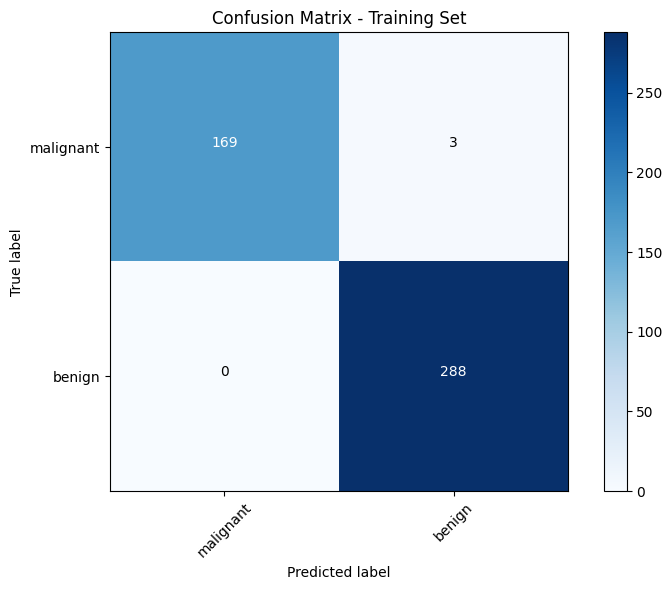


Classification Report - Training Set:

              precision    recall  f1-score   support

   malignant     1.0000    0.9826    0.9912       172
      benign     0.9897    1.0000    0.9948       288

    accuracy                         0.9935       460
   macro avg     0.9948    0.9913    0.9930       460
weighted avg     0.9935    0.9935    0.9935       460



In [ ]:
# Evaluate the model on the training set
evaluate_model(best_model, X_train_scaled, y_train, "Training Set")


The result of the confusion matrix shows that the training set accurately classified 169/172 malignant cases yielding a true positive rate of 98.26%. It also correctly identified 282 out of 288 benign ones, resulting in a true negative rate of 97.92%. However, the model misclassified 3 malignant cases predicted as benign, resulting in a false negatives rate of 1.74% and 6 benign cases classified as malignant, resulting in a false positives rate of 2.08%.

The classification report indicates an overall accuracy of 98.04%, with precision scores of 0.9657 for malignant and 0.9895 for benign cases. The recall values of 0.9826 for malignant and 0.9792 for benign cases. The corresponding F1 scores were 0.9741 for malignant and 0.9843 for benign. Macro-averaged metrics were 0.9776 (precision), 0.9809 (recall), and 0.9792 (F1-score), while the weighted averages were 0.9806, 0.9804, and 0.9805, respectively—highlighting robust classification performance across both classes.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


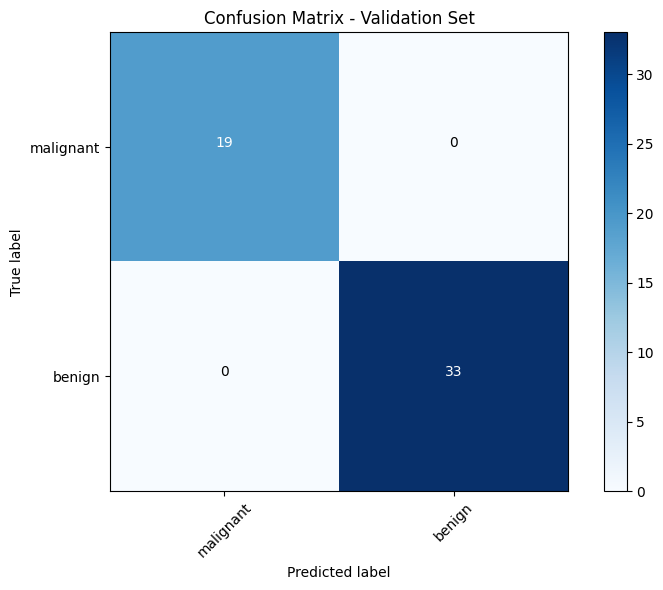


Classification Report - Validation Set:

              precision    recall  f1-score   support

   malignant     1.0000    1.0000    1.0000        19
      benign     1.0000    1.0000    1.0000        33

    accuracy                         1.0000        52
   macro avg     1.0000    1.0000    1.0000        52
weighted avg     1.0000    1.0000    1.0000        52



In [ ]:
# Evaluate the model on the Validation set
evaluate_model(best_model, X_val_scaled, y_val, "Validation Set")


The confusion matrix for the validation set demonstrates perfect classification performance. All 19 malignant cases were correctly identified by the model, resulting in a true postive rate of 100%. It also correctly identified all 33 benign ones, resulting in a true negative rate of 100%. Consequently, there were no false positives and no false negatives, corresponding to false negative and false positive rates of 0%, respectively.

The classification report further supports this outcome, showing that the model achieved an accuracy of 100% on the validation set. Moreover, it attained perfect precision, recall, and F1 scores for both classes. It also had a percent weight average and macro average.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


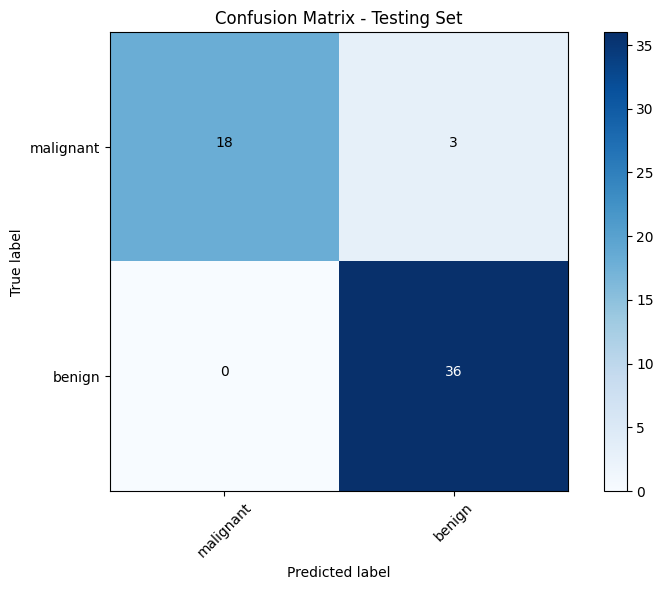


Classification Report - Testing Set:

              precision    recall  f1-score   support

   malignant     1.0000    0.8571    0.9231        21
      benign     0.9231    1.0000    0.9600        36

    accuracy                         0.9474        57
   macro avg     0.9615    0.9286    0.9415        57
weighted avg     0.9514    0.9474    0.9464        57



In [ ]:
# Evaluate the model on the Testing set
evaluate_model(best_model, X_test_scaled, y_test, "Testing Set")

The confusion matrix for the test set demonstrates that the model correctly classified 19 out of 21 malignant cases, resulting in a true positive rate of 90.48%. The test set also had correctly classified 35 out of 36 benign cases, yielding a true negative rate of 97.22%. This indicates the presence of 2 false negatives and 1 false positive, corresponding to a false negative rate of 9.52% and a false positive rate of 2.78%, respectively.

The classification report reinforces these findings, with the model achieving an overall accuracy of 94.74% on the test set. The precision score for the malignant class was 0.9500, while the benign class achieved a precision of 0.9459. The recall was 0.9048 for malignant cases and 0.9722 for benign cases. The corresponding F1 scores were 0.9268 for malignant and 0.9589 for benign. Additionally, the macro-averaged metrics were 0.9480 for precision, 0.9385 for recall, and 0.9429 for F1 score. The weighted averages were 0.9474 for precision, 0.9474 for recall, and 0.9471 for the F1 score.